# Stock Price Indication Using Sentiment Analysis

## Introduction

   Predicting the stock price is a really challenging research topic. Various factors that affect stock price include industry performance, economic outlook, change in economic and political policies and so on. Among these factors, investors' sentiment plays an crucial role in the fluctuation of stock price: whether people are optimistic or not towards the market. Thus, I decided to do a project on using sentiment analysis to predict stock price. 

## Data

   In this project, I used twitter as a source for gathering people's sentiment. Stock price data is downloaded from Yahoo finance. Date ranges from 2018 to 2020. To fetch data from twitter, I used twitter scraper API.  It turns out that the hardest part in this project is to select twitter data properly -- tweets that properly represent investors' sentiment towards a specific stock. 

## Text Processing

   General text processing includes removing punctuations, stop words, and lowercassing all words. For tweets, we need to do more cleaning. As shown below, tweets contain lots of stock abbreviations, urls, user tags, picture and video links, and many "\n" remained from parsing the original multiple-lined tweets. Part of the code is shown below. 

In [114]:
AAPL = pickle.load(open('tweets/AAPL_tweets.pickle', 'rb'))
print(AAPL.text.head())

0    Stock Market Legend First Ever Forecasting Apple to Acquire Netflix in 2018 $AAPL $NFLX $QQQ $SPX #apple #netflix https://stockmarketlive.tv/2017/06/21/buffett-lose-hundreds-millions-dollars-apple-acquire-netflix/#.WkrKgRNSy0o …
1    Traders are betting billions that the hottest stocks of 2017 will get crushed (FB, AAPL, AMZN, GOOG, NFLX) | https://buff.ly/2leJU6Y pic.twitter.com/tSD1b2dSFD                                                                     
2    RT @businessinsider: There is a 40% chance Apple will acquire Netflix, according to Citi $AAPL $NFLX http://read.bi/2DHIqt0 pic.twitter.com/D7iTVlwKXu                                                                              
3    There is a 40% chance #Apple will acquire #Netflix, according to Citi (AAPL, NFLX) https://finance.yahoo.com/news/40-chance-apple-acquire-netflix-084744946.html?soc_src=social-sh&soc_trk=tw … via @YahooFinance                   
4    Join @RobinhoodApp and we'll both get a share of stock like

In [115]:
symbols = [symbol.lower() for symbol in pd.read_csv('symbols.csv').Symbol]


# remove URLs, picure and video links, tags started with @, #, and $. 
def remove_junks(words):
    return re.sub(r"http\S+|\S*@\S+|videospic\S+|pic\S+|#\S+|\d+|\S+\.\S+|\$\S+", "", words)

# remove stock symbols.
def remove_tags(sentence):
    sentence_list = sentence.split(" ")
    new_sentence = ""
    
    # Since a lot of stock symbols come with parentheses around them, strip the "()" first
    for word in sentence_list:
        if word.strip('()') not in symbols:
            new_sentence += word + " "
    return new_sentence

# remove new line character
def remove_backslash(sentence):
    return sentence.replace("\n", "")

In particular, for nltk vader sentiment analysis, I did not remove punctuations, stopword and uppercase because nltk vader can recognize them as part of sentimental expression. Below shows examples of how punctuation and uppercase affect sentiment score. Comparing sentence 1 with sentence 2, the exclamation mark at the end of the sentence add the positive score. Comparing sentence 2 with sentence 3, the uppercases also add the positive score. 

In [116]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

Analyzer = SentimentIntensityAnalyzer()

def sentence_score(sentence):
    tokenized_sentence = nltk.word_tokenize(sentence)
    pos_word_list = []
    neu_word_list = []
    neg_word_list = []

    for word in tokenized_sentence:
        if (Analyzer.polarity_scores(word)['compound']) >= 0.1:
            pos_word_list.append(word)
        elif (Analyzer.polarity_scores(word)['compound']) <= -0.1:
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)

    print('Positive:', pos_word_list)
    print('Neutral:', neu_word_list)
    print('Negative:', neg_word_list)
    score = Analyzer.polarity_scores(sentence)
    print('Scores:', score)
    
    
sentence1 = 'It is not bad.'
sentence2 = 'It is not bad!!!'
sentence3 = 'It is NOT BAD!!!'

sentence_score(sentence1)
sentence_score(sentence2)
sentence_score(sentence3)


Positive: []
Neutral: ['It', 'is', 'not', '.']
Negative: ['bad']
Scores: {'neg': 0.0, 'neu': 0.513, 'pos': 0.487, 'compound': 0.431}
Positive: []
Neutral: ['It', 'is', 'not', '!', '!', '!']
Negative: ['bad']
Scores: {'neg': 0.0, 'neu': 0.446, 'pos': 0.554, 'compound': 0.5756}
Positive: []
Neutral: ['It', 'is', 'NOT', '!', '!', '!']
Negative: ['BAD']
Scores: {'neg': 0.0, 'neu': 0.413, 'pos': 0.587, 'compound': 0.6449}


   Another thing to notice is that for nltk vader, we don't want to remove stopwords. NLTK stopwords list contain "not", "don't" and other negation words, which will change the sentiment polarity completely. 

## Sentiment Analysis

### NLTK Vader

NLTK.Vader is a prebuilt python sentiment analyzer. It can handle general sentiment analysis, as well as negation and  semantic changes in a sentence. However, The NLTK Vader's word list does not include finance-related sentiment words such as "increase", "fall", "bankruptcy" etc. Thus, I update the nltk's general lexicon by adding the Loughran & Mcdonald lexicon, which is developed specifically for finance.

In [117]:
# Read the Loughran & McDonald word list
lm_wordlist = pd.ExcelFile('LoughranMcDonald_SentimentWordLists_2018.xlsx')
positive = pd.read_excel(lm_wordlist, 'Positive', header= None, names= "P")
negative = pd.read_excel(lm_wordlist, 'Negative', header = None, names = "N")

# Assign positive and negative scores to words.
positive["score"] = 1
negative["score"] = -1
word_dict, negative_dict = dict(zip(positive["P"], positive["score"])), dict(zip(negative["N"], negative["score"]))
word_dict.update(negative_dict)

# Update the analyzer.
Analyzer = SentimentIntensityAnalyzer()
Analyzer.lexicon.update(word_dict)

In [119]:
def analyze(df):

    sent = {}
    pos = []
    neg = []
    com = []
    neu = []
    i = 0
    for date, data in df.iterrows():
        i+=1
        sent[i] = Analyzer.polarity_scores(str(data.text))
        pos.append(sent[i]['pos'])
        neg.append(sent[i]['neg'])
        neu.append(sent[i]['neu'])
        com.append(sent[i]['compound'])

    analyzed_df = pd.DataFrame(df[['text', 'timestamp']])

    analyzed_df['text_positive'] = pos
    analyzed_df['text_negative'] = neg
    analyzed_df['text_neutral'] = neu
    analyzed_df['text_compound'] = com
    return analyzed_df

### Bag of Words technique

Another popular method for sentiment analysis is bag of words. We first count the occurence of words from all tweets, select K mostly appeared words, and calculate the occurence of these words in each tweet. A weekness of this technique is that it destroys the original semantics.

In [258]:
def bag_of_words(df):
    df_bow = df.copy(deep = True)
    df_bow['text'] = df_bow['text'].apply(text_processing_bow)
    word2count = {}
    for data in df_bow.text:
        words = nltk.word_tokenize(data)
        for word in words:
            if word not in word2count.keys():
                word2count[word] = 1
            else:
                word2count[word] += 1

    freq_words = heapq.nlargest(150, word2count, key=word2count.get)
    freq_dict = dict(zip(freq_words, [0 for i in range(len(freq_words))]))
    print(freq_dict)


    def tokenize(sentence):
        vector = copy.deepcopy(freq_dict)
        for word in sentence:
            if word in freq_dict:
                vector[word] += 1

        return vector.values()

    df_bow['text'] = df_bow['text'].apply(tokenize)
    return df_bow

## Implementation

I started by looking at the relationship between the Nasdaq stock market and nasdaq-related tweets' sentiment scores. Below are plots showing text_compound score VS market price and text_negative score VS market price.

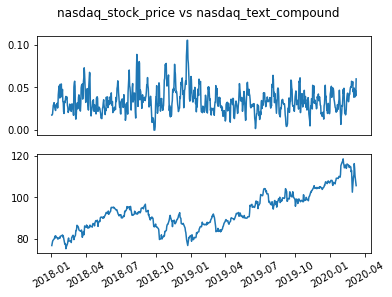

In [235]:
y_nasdaq_compound = sentiment_score_nasdaq.text_compound
y_nasdaq_list = pd.Series.tolist(y_nasdaq_compound)
y__nasdaq_average = smoothen(y_nasdaq_list, 4)
fig, axs = plt.subplots(2)
fig.suptitle('nasdaq_stock_price vs nasdaq_text_compound')
axs[0].plot(x_nasdaq, y_nasdaq_average)
axs[1].plot(nasdaq_price.Date, nasdaq_price.Close)
axs[0].tick_params(axis = "x", which = "both", bottom = False, top = False, labelbottom = False)
plt.xticks(rotation = 30)
plt.show()

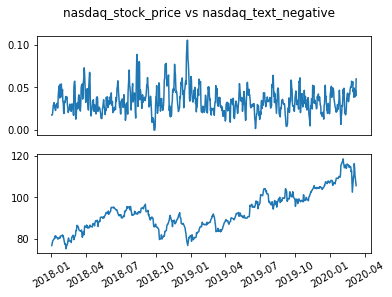

In [234]:
x_nasdaq = sentiment_score_nasdaq.index
y_nasdaq_negative = sentiment_score_nasdaq.text_negative
y_nasdaq_list = pd.Series.tolist(y_nasdaq_negative)

y_nasdaq_average = smoothen(y_nasdaq_list, 4)
fig, axs = plt.subplots(2)
fig.suptitle('nasdaq_stock_price vs nasdaq_text_negative')
axs[0].plot(x_nasdaq, y_nasdaq_average)
axs[1].plot(nasdaq_price.Date, nasdaq_price.Close)
axs[0].tick_params(axis = "x", which = "both", bottom = False, top = False, labelbottom = False)
plt.xticks(rotation = 30)
plt.show()

From the graphs above, we don't see an apparent relationship between sentiment scores and market price. The reason could be that the market price as a whole is relatively stable. Thus, I looked at the relationship between a single stock's daily price and its sentiment scores. I used Apple as an example. Below are plots for Apple stock price VS text compounds and Apple stock price VS text negative. 

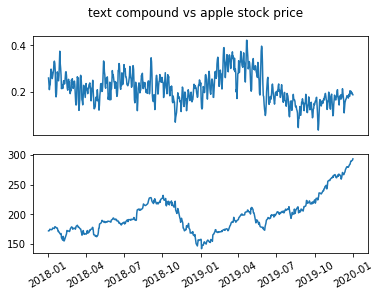

In [126]:
y_compound = analyzed.text_compound
y_list = pd.Series.tolist(y_compound)
y_average = smoothen(y_list, 4)
fig, axs = plt.subplots(2)
fig.suptitle('text compound vs apple stock price')
axs[0].plot(x, y_average)
axs[1].plot(AAPL_price.Date, AAPL_price.Close)
axs[0].tick_params(axis = "x", which = "both", bottom = False, top = False, labelbottom = False)
plt.xticks(rotation = 30)
plt.show()

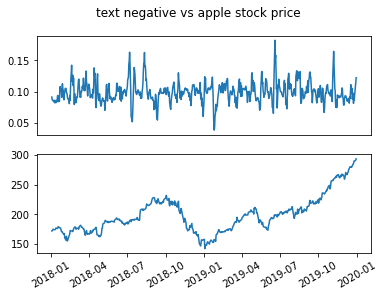

In [219]:
x = analyzed.index
y_negative = analyzed.text_negative
y_list = pd.Series.tolist(y_negative)
y_average = smoothen(y_list, 4)
fig, axs = plt.subplots(2)
fig.suptitle('text negative vs apple stock price')
axs[0].plot(x, y_average)
axs[1].plot(AAPL_price.Date, AAPL_price.Close)
axs[0].tick_params(axis = "x", which = "both", bottom = False, top = False, labelbottom = False)
plt.xticks(rotation = 30)
plt.show()

From the graph, we did not find an apparent pattern between the stock price and sentiment scores. This could be due to the lack of useful sentiments in the fetched tweets. Large amount of the tweets don't indicate what people think about the stock and the market. Below are some examples of those tweets. Thus, it is hard to find a pattern between the sentiment score and the price. However, I did not find a good way of filtering out non-related tweets other than trying different combinations of keywords, which turned out to be not effective.

In [225]:
AAPL_tweets = pickle.load(open('tweets/AAPL_tweets.pickle', 'rb'))
print(AAPL_tweets.text.head())

0    Stock Market Legend First Ever Forecasting Apple to Acquire Netflix in 2018 $AAPL $NFLX $QQQ $SPX #apple #netflix https://stockmarketlive.tv/2017/06/21/buffett-lose-hundreds-millions-dollars-apple-acquire-netflix/#.WkrKgRNSy0o …
1    Traders are betting billions that the hottest stocks of 2017 will get crushed (FB, AAPL, AMZN, GOOG, NFLX) | https://buff.ly/2leJU6Y pic.twitter.com/tSD1b2dSFD                                                                     
2    RT @businessinsider: There is a 40% chance Apple will acquire Netflix, according to Citi $AAPL $NFLX http://read.bi/2DHIqt0 pic.twitter.com/D7iTVlwKXu                                                                              
3    There is a 40% chance #Apple will acquire #Netflix, according to Citi (AAPL, NFLX) https://finance.yahoo.com/news/40-chance-apple-acquire-netflix-084744946.html?soc_src=social-sh&soc_trk=tw … via @YahooFinance                   
4    Join @RobinhoodApp and we'll both get a share of stock like

The pearson correlation coefficience between text compound and stock price is 0.276, which indicates the apple sentiment scores and stock price are not strongly correlated.

In [221]:
print(stats.pearsonr(y_compound.iloc[:503], AAPL_price.Close))

(0.2760245870598415, 3.0161883991961024e-10)


In [128]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

   Then, we add labels to the data and combine four stock and build machine learning classifiers.  Classifiers I tried are GaussianNB, Logistic Regression, RandomForest and Gradientboost. 

In [129]:
AAPL_price.drop(['Open', 'High', 'Low','Volume', 'Adj Close'], axis = 1, inplace=True)
AAPL_joined = AAPL_price.set_index("Date").join(analyzed).reset_index()
AAPL_joined['label'] = AAPL_joined['Close'] - AAPL_joined['Close'].shift(1)
AAPL_joined['label'] = AAPL_joined['label'].apply(lambda x: 0 if x <0 else 1)
AAPL_joined['label'] = AAPL_joined['label'].shift(-1)
AAPL_joined.dropna(inplace = True)

AMZN_analyzed = analyze(AMZN)
AMZN_analyzed = AMZN_analyzed.groupby('timestamp').mean()

AMZN_price.drop(['Open', 'High', 'Low','Volume', 'Adj Close'], axis = 1, inplace=True)
AMZN_joined = AMZN_price.set_index("Date").join(AMZN_analyzed).reset_index()
AMZN_joined['label'] = AMZN_joined['Close'] - AMZN_joined['Close'].shift(1)
AMZN_joined['label'] = AMZN_joined['label'].apply(lambda x: 0 if x <0 else 1)
AMZN_joined['label'] = AMZN_joined['label'].shift(-1)
AMZN_joined.dropna(inplace = True)

WMT_analyzed = analyze(WMT)
WMT_analyzed = WMT_analyzed.groupby('timestamp').mean()

WMT_price.drop(['Open', 'High', 'Low', 'Volume', 'Adj Close'], axis=1, inplace=True)
WMT_joined = WMT_price.set_index("Date").join(WMT_analyzed).reset_index()
WMT_joined['label'] = WMT_joined['Close'] - WMT_joined['Close'].shift(1)
WMT_joined['label'] = WMT_joined['label'].apply(lambda x: 0 if x < 0 else 1)
WMT_joined['label'] = WMT_joined['label'].shift(-1)
WMT_joined.dropna(inplace = True)

FB_analyzed = analyze(FB)
FB_analyzed = FB_analyzed.groupby('timestamp').mean()

FB_price.drop(['Open', 'High', 'Low', 'Volume', 'Adj Close'], axis=1, inplace=True)
FB_joined = FB_price.set_index("Date").join(FB_analyzed).reset_index()
FB_joined['label'] = FB_joined['Close'] - FB_joined['Close'].shift(1)
FB_joined['label'] = FB_joined['label'].apply(lambda x: 0 if x < 0 else 1)
FB_joined['label'] = FB_joined['label'].shift(-1)
FB_joined.dropna(inplace = True)


data = pd.concat([WMT_joined, AMZN_joined, AAPL_joined, FB_joined]).reset_index(drop=True).drop('Date', axis = 1)

X = data[['text_positive', 'text_negative', 'text_neutral', 'text_compound']]
y = data['label']

#### Previous days effect on future price change?

  Since both sentiment and stock price are time series that have relation between days, I added labels and sentiment 
    scores within 3 previous days to the model. It turned out that GaussianNB and LR have the best performance. Best 
    accuracy is around 53%, a little higher than a random guess.

In [134]:
add_prev(data, 'label', 1)
add_prev(data, 'label', 2)
add_prev(data, 'label', 3)
add_prev(data, 'text_positive', 1)
add_prev(data, 'text_positive', 2)
add_prev(data, 'text_positive', 3)
add_prev(data, 'text_negative', 1)
add_prev(data, 'text_negative', 2)
add_prev(data, 'text_negative', 3)
data.dropna(inplace=True)

# Text_compound has correlation with text_positive, text_negative and text_neutral, drop it

# try more columns 
X = data.drop(['text_compound', 'label'], axis=1)
y = data['label']

#### Performance of different machine learning models:

In [184]:
scores_nb = cross_val_score(gnb, X, y, cv=5)
print("Score for GaussianNB is: ", np.mean(scores_nb), np.std(scores_nb))

Score for GaussianNB is:  0.5288689034936008 0.010512525880523906


In [185]:
scores_lr = cross_val_score(lr, X, y, cv=5)
print("Score for LR is: ",np.mean(scores_lr), np.std(scores_lr))

Score for LR is:  0.5315577078288943 0.01535351958880145


In [186]:
scores_grb = cross_val_score(grb, X, y, cv=5)
print("Score for GradientBoost is: ", np.mean(scores_grb), np.std(scores_grb))

Score for GradientBoost is:  0.5044113916753141 0.029098040874083138


In [187]:
scores_rf = cross_val_score(rf, X, y, cv=5)
print("Score for RandomForest is: ",np.mean(scores_rf), np.std(scores_rf))

Score for RandomForest is:  0.4969376225066299 0.030985272912317587


Then, I tried to include 3 more previous days and tested with classifiers. There wasn't an apparent increase in scores, which indicated days added were not important for the model, although LR score does increase from 53% to 54%, a slight improvement.

In [236]:
add_prev(data, 'label', 4)
add_prev(data, 'label', 5)
add_prev(data, 'label', 6)
add_prev(data, 'text_positive', 4)
add_prev(data, 'text_positive', 5)
add_prev(data, 'text_positive', 6)
add_prev(data, 'text_negative', 4)
add_prev(data, 'text_negative', 5)
add_prev(data, 'text_negative', 6)
data.dropna(inplace=True)

In [237]:
X = data.drop(['text_compound','label'], axis=1)
y = data['label']

In [238]:
scores_nb = cross_val_score(gnb, X, y, cv=10)
print("Score for GaussianNB is: ", np.mean(scores_nb), np.std(scores_nb))

Score for GaussianNB is:  0.5229195787904203 0.0272138876646781


In [239]:
scores_lr = cross_val_score(lr, X, y, cv=10)
print("Score for LR is: ",np.mean(scores_lr), np.std(scores_lr))

Score for LR is:  0.5448327276115926 0.006214099916741905


In [203]:
scores_grb = cross_val_score(grb, X, y, cv=5)
print("Score for GradientBoost is: ", np.mean(scores_grb), np.std(scores_grb))

Score for GradientBoost is:  0.4983120893408558 0.02288577403104869


In [204]:
scores_rf = cross_val_score(rf, X, y, cv=5)
print("Score for RandomForest is: ",np.mean(scores_rf), np.std(scores_rf))

Score for RandomForest is:  0.505829908755311 0.030495332820589634


Below I used Chi-square method and the SelectKBest method from Sklearn to find the most important variable. As shown 
below, the Close price turned out to be the most important variable.

In [216]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


# Feature extraction
test = SelectKBest(score_func=chi2, k=3)
fit = test.fit(X, y)

# Summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)

features = fit.transform(X)
# Summarize selected features
print(features[0:5,:])
print(X.head())

[5.060e+01 6.759e-03 1.516e-02 3.215e-06 2.030e-02 7.739e-02 4.221e-03
 1.434e-03 1.353e-05 1.678e-03 1.301e-05 1.578e-02 1.943e-04 7.739e-02
 1.307e-01 4.014e-01 1.121e-03 2.949e-02 8.658e-03 8.798e-03 1.202e-03
 2.240e-03]
[[105.79   1.     1.  ]
 [106.6    1.     1.  ]
 [108.39   1.     1.  ]
 [109.55   1.     1.  ]
 [107.73   0.     1.  ]]
         Close  text_positive  text_negative  text_neutral  prev_label_1  \
6   105.790001  0.044278       0.028833       0.926889      0.0            
7   106.599998  0.109000       0.079053       0.811895      1.0            
8   108.389999  0.135556       0.037333       0.827111      1.0            
9   109.550003  0.090750       0.030450       0.878850      1.0            
10  107.730003  0.034800       0.081200       0.884050      0.0            

    prev_label_2  prev_label_3  prev_text_positive_1  prev_text_positive_2  \
6   1.0           1.0           0.072895              0.065833               
7   0.0           1.0           0.044278 

#### LSTM Model

   We also implemented keras LSTM for building the model. 

In [ ]:
from keras.layers import LSTM
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sentiment_analysis_nltk import analyze
from single_stock_analysis import add_prev
from tweets_processing import text_processing
AAPL_rnn_X = data_prev.drop("label", axis=1).to_numpy()
AAPL_rnn_y = data_prev[['label']].to_numpy()

AAPL_rnn_X = np.reshape(AAPL_rnn_X, (AAPL_rnn_X.shape[0], AAPL_rnn_X.shape[1], 1))


model2 = Sequential()
model2.add(LSTM(units=50, return_sequences=True, input_shape= (AAPL_rnn_X.shape[1], 1)))
model2.add(Dense(1))
model2.add(Flatten())
model2.add(Dense(1,activation = 'sigmoid'))


model2.compile(loss='mean_squared_error', optimizer= "Adadelta",
              metrics=['acc'])
history2 = model2.fit(AAPL_rnn_X, AAPL_rnn_y,
                    epochs=10,
                    batch_size=10,
                    validation_split=0.2)

acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

<img src = "train_val_acc.png" style = "width:400px; height: 300px"/>

<img src = "tra_val_loss.png" style = "width:400px; height: 300px"/>

    The validation accuracy for lstm is around 0.6, which is higher than GaussianNB and LR. 

Then, I tried fetch tweets focusing on more general financial news, rather than tweets related to a specific stock or a stock market. I choosed the @FinancialTimes as the source, which is an official financial news account on twitter.

In [246]:
FT = pickle.load(open('tweets/FinancialTimes_tweets.pickle', 'rb'))
ndaq_price = pd.read_csv("prices/NDAQ.csv")
ndaq_price['Date'] = pd.to_datetime(ndaq_price['Date'])
FT['timestamp'] = pd.to_datetime(FT['timestamp'])
FT.text = FT['text'].apply(text_processing)
analyzed = analyze(FT)
analyzed = analyzed.groupby('timestamp').mean()

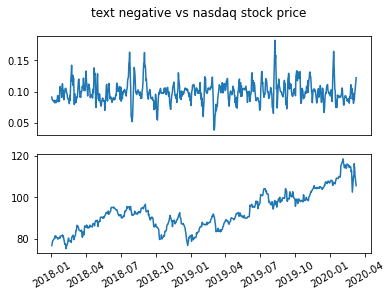

In [163]:
x = analyzed.index
y_negative = analyzed.text_negative
y_list = pd.Series.tolist(y_negative)
y_average = smoothen(y_list, 4)
fig, axs = plt.subplots(2)
fig.suptitle('text negative vs nasdaq stock price')
axs[0].plot(x, y_average)
axs[1].plot(ndaq_price.Date, ndaq_price.Close)
axs[0].tick_params(axis = "x", which = "both", bottom = False, top = False, labelbottom = False)
plt.xticks(rotation = 30)

plt.show()

    Again, we don't find relation between these two variables. The reason should still lies in the data. The tweets from FinancialTimes are too general against a stock market. Below shows some example tweets.

In [245]:
print(FT.text.head())

0    And Japan is perhaps the only comparable economy in the world to Britain's, a resource and agriculture poor mature economy.                                                                                                                           
1    Apprenticeships are for everyone, not just an ‘elite’  … via                                                                                                                                                                                          
2    Draining of  punchbowl sobers up  bulls -yr US Treasury yield seen rising to .% from .%,German Bund yield to rise to .% from .%,the -yr UK yield to .% from .%&Japanese -yr to .% from .% by end-  … via                                              
3    Fee cap hits businesses using apprenticeship levy for MBAs  … via                                                                                                                                                                              

## Conclusion and Future Works

Among the prediction scores, LSTM has the best performance with a 0.6 validation accuracy, which could still be enhanced by feeding more data. Logistic Regression has a score of 0.54, GaussianNB has 0.53.  


I did not get a satisfying results from stock price prediction. The main reason is due to the limitation on data. By passing in searching keyword is not enough for filtering useful tweets. This could be solved by developing a NLP filter in the future. Another problem is about the sentiment analysis. Although I updated the nltk lexicon with financial lexicon, I did not specify the sentiment score for each word since there were so many of them and I could not go through the list and assign them with proper scores. Also, people tend to favor metaphor and irony in posting tweets, which makes it hard to assign appropriate sentiment score for tweets. This could be solved by implementing a sentiment analyzer specifically for financial tweets in the future.
    
This project is more like a tour in the realm of finance, machine learning and data science. Although the predicting result is unsatisfying, I learned a lot of knowledge about finance, about machine learning concepts, models, sentiment analysis and text processing techniques. The part I did not complete is the study of time series analysis, for which I am going to learn in the future. It will be really helpful for predicting the stock price.

    Besides, I would like to thank my mentor Dr. Lisa Torrey for all the support and guidance during the project.

## Reference

    https://www.getsmarteraboutmoney.ca/invest/investment-products/stocks/factors-that-can-affect-stock-prices/
    
    Anurag Nagar and Michael Hahsler, "Using Text and Data Mining Techniques to extract Stock MarketSentiment from Live News     Streams"
    
    Kari Lee and Ryan Timmons, "Predicting the Stock Market with News Articles".
    
    Fung, Gabriel, et. al. "The Predicting Power of Textual Information on Financial Markets". IEEE Intelligent Informatics Bulletin. Vol. 5. No. 1. June 2005.
    
    Dev Shah, Haruna Isah and Farhana Zulkernine, "Predicting the Effects of News Sentiments on the Stock Market"
    Saloni Mohan, Sahitya Mullapudi, Sudheer Sammeta, Parag Vijayvergia and David C. Anastasiu, "Stock Price Prediction 
    Using News Sentiment Analysis".
    
    Kalyani Joshi, Prof. Bharathi H. N., Prof. Jyothi Rao, "Stock Trend Prediction Using Sentiment Analysis"
    
    François Chollet, Deep Learning with Python.
    
    https://www.freecodecamp.org/news/an-introduction-to-bag-of-words-and-how-to-code-it-in-python-for-nlp-282e87a9da04/